In [57]:
import numpy as np
import matplotlib.pyplot as plt
from aif360.sklearn.metrics import average_odds_difference
from aif360.sklearn.metrics import equal_opportunity_difference
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
from fairlearn.metrics import (
    MetricFrame,
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
    demographic_parity_difference,
    true_positive_rate,
    true_negative_rate
)
from fairlearn.datasets import fetch_adult
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.termination import get_termination
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.visualization.scatter import Scatter

import dill


In [3]:
data = fetch_adult(as_frame=True)
X_raw = data.data
y = (data.target == ">50K") * 1
A = X_raw["sex"]

features = X_raw.columns
n_cols = len(X_raw.columns)
num_features = X_raw._get_numeric_data().columns
cat_features =  [col for col in X_raw.columns if col not in num_features]

numeric_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scaler", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
        
    ], remainder = "drop"
)


pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            LGBMClassifier(n_jobs=-1)
        ),
    ]
)

/home/azucena/miniconda3/envs/fairenv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
# file_name = 'results_01.pkl'
# with open(file_name, 'rb') as in_strm:
#        results_01 = dill.load(in_strm)

# file_name = 'results_2.pkl'
# with open(file_name, 'rb') as in_strm:
#     results_2 = dill.load(in_strm)

# file_name = 'results_3.pkl'
# with open(file_name, 'rb') as in_strm:
#     results_3 = dill.load(in_strm)

# results = results_01 + results_2 + results_3

In [5]:
# file_name = 'results_01_v2.pkl'
# with open(file_name, 'rb') as in_strm:
#     results_01 = dill.load(in_strm)

# file_name = 'results_23_v2.pkl'
# with open(file_name, 'rb') as in_strm:
#     results_2 = dill.load(in_strm)

# results = results_01 + results_2 

In [21]:
file_name = 'results_disparity_01.pkl'
with open(file_name, 'rb') as in_strm:
     results_01 = dill.load(in_strm)

file_name = 'results_disparity_23.pkl'
with open(file_name, 'rb') as in_strm:
    results_2 = dill.load(in_strm)

results = results_01 + results_2 

In [135]:
#n = 3
#n_evals = np.array([e.evaluator.n_eval for e in results[n].history])
#opt = np.array([e.opt[0].F for e in results[n].history])

#plt.title("Convergence")
#plt.plot(n_evals, opt, "--")
#plt.yscale("log")
#plt.show()

In [4]:
#from pymoo.util.running_metric import RunningMetricAnimation

#running = RunningMetricAnimation(delta_gen=5,
#                        n_plots=3,
#                        key_press=False,
#                        do_show=True)

#for algorithm in results[n].history[:15]:
#    running.update(algorithm)



In [22]:
fair_sim_u = []
model_sim_u = []
fair_sim = []
model_sim = []
for sim_n,res in enumerate(results):
    (X_train, X_test, y_train, y_test, A_train, A_test) = train_test_split(
    X_raw, y, A, test_size=0.3, stratify=y, random_state=sim_n
    )

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    A_train = A_train.reset_index(drop=True)
    A_test = A_test.reset_index(drop=True)

    fair_value = []
    model_value = []
    order = results[sim_n].F[:,0].argsort()
    pop = results[sim_n].opt

    for n_pop in order:

        features_ = features[pop.get("X")[n_pop]]
        num_features_ = [x for x in num_features if x in features_]
        cat_features_ = [x for x in cat_features if x in features_]
        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, num_features_),
                ("cat", categorical_transformer, cat_features_),
                
            ], remainder = "drop"
        )

        pipeline.steps.pop(0)
        pipeline.steps.insert(0,('preprocessor',preprocessor))
        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)
        fair_value.append(np.abs(demographic_parity_difference(y_test, y_pred, sensitive_features=A_test)))
        model_value.append(f1_score(y_test, y_pred))

    fair_sim.append(fair_value)
    model_sim.append(model_value)


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_features),
            ("cat", categorical_transformer, cat_features),
            
        ], remainder = "drop"
    )

    pipeline.steps.pop(0)
    pipeline.steps.insert(0,('preprocessor',preprocessor))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    fair_sim_u.append((np.abs(demographic_parity_difference(y_test, y_pred, sensitive_features=A_test))))
    model_sim_u.append(f1_score(y_test, y_pred))

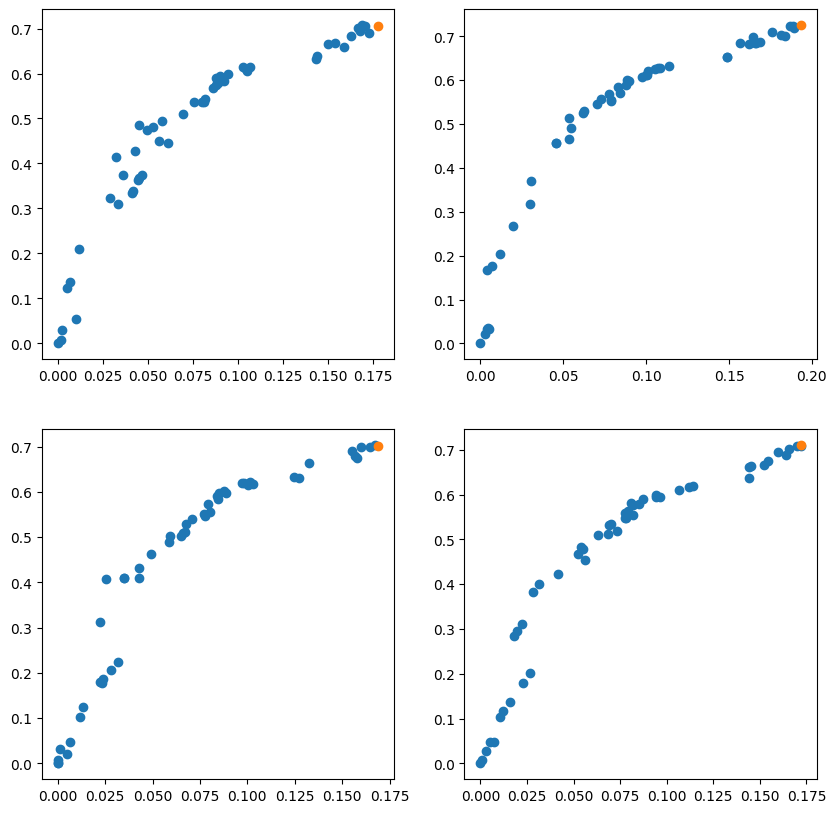

In [23]:
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(fair_sim)),axes.ravel()):
    ax.scatter(fair_sim[i], model_sim[i])
    ax.scatter(fair_sim_u[i], model_sim_u[i])

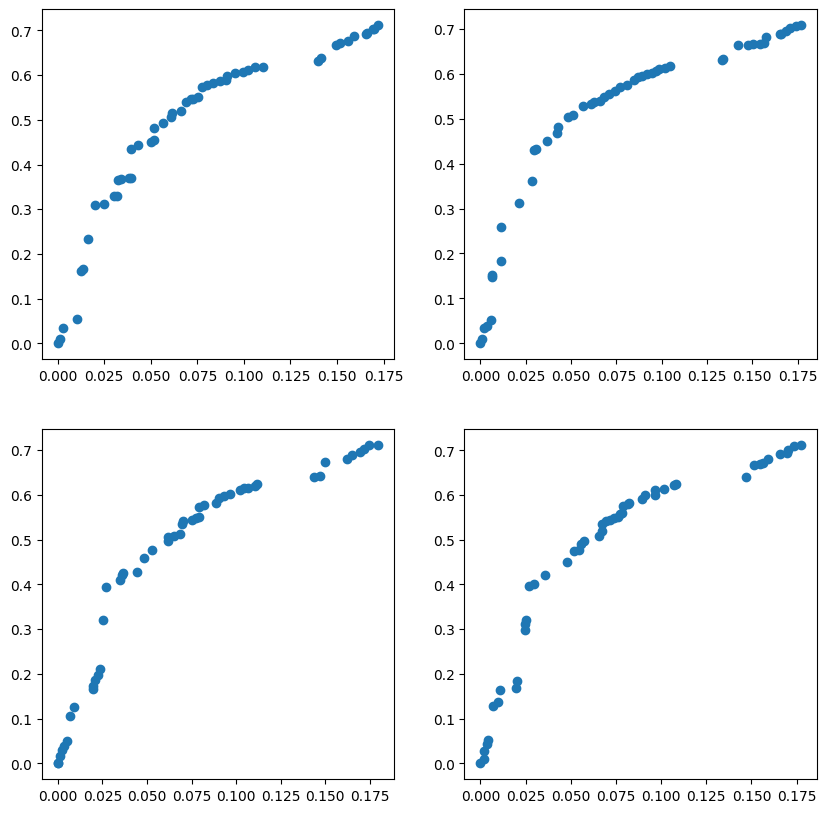

In [24]:
arows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(fair_sim)),axes.ravel()):
    order = results[i].F[:,0].argsort()
    ax.scatter(results[i].F[order,0],np.abs(results[i].F[order,1]))
    #ax.scatter(fair_sim_u[i], model_sim_u[i])


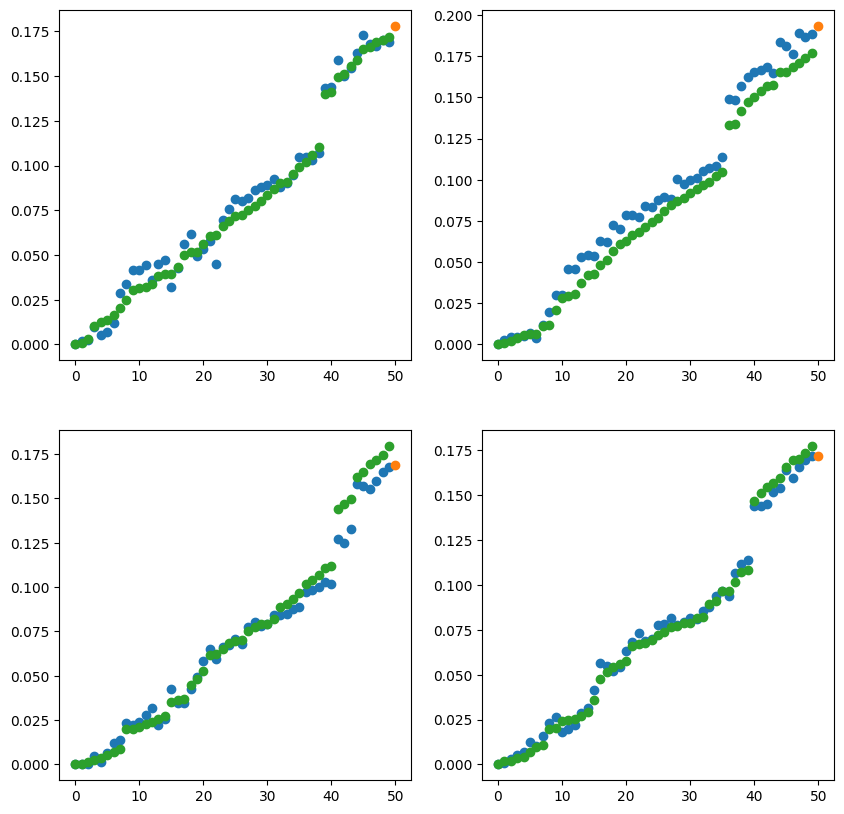

In [25]:
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(fair_sim)),axes.ravel()):
    ax.scatter(range(len(fair_sim[i])),fair_sim[i])
    ax.scatter(len(fair_sim[i]), fair_sim_u[i])
    order = results[i].F[:,0].argsort()
    ax.scatter(range(len(fair_sim[i])), results[i].F[order,0])

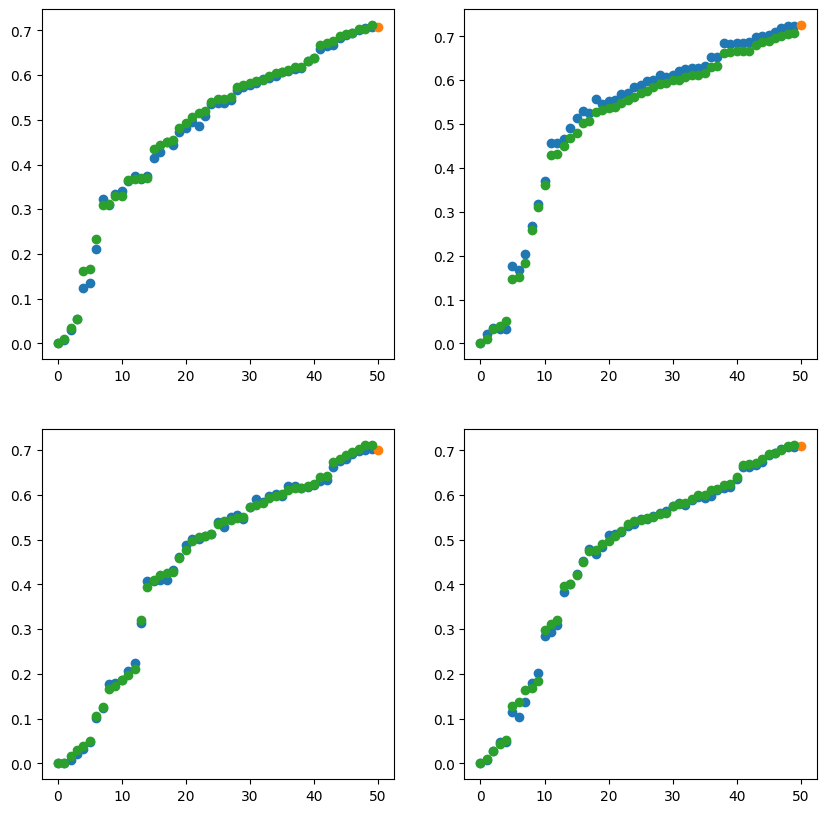

In [26]:
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(fair_sim)),axes.ravel()):
    ax.scatter(range(len(fair_sim[i])),model_sim[i])
    ax.scatter(len(fair_sim[i]), model_sim_u[i])
    order = results[i].F[:,0].argsort()
    ax.scatter(range(len(model_sim[i])), np.abs(results[i].F[order,1]))

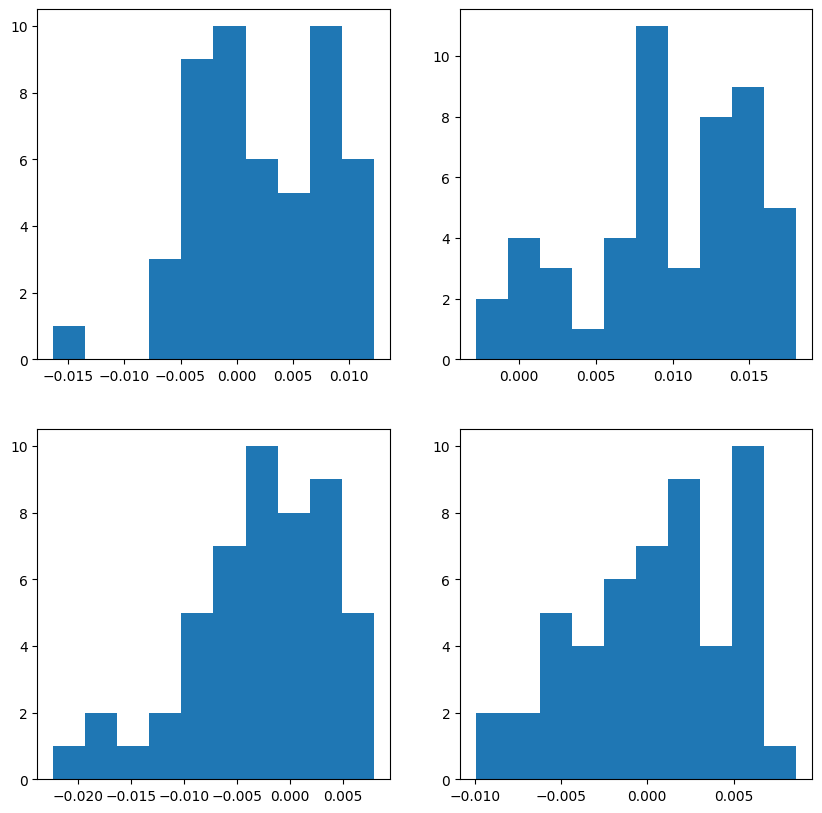

In [27]:
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(fair_sim)),axes.ravel()):
    order = results[i].F[:,0].argsort()
    fair_residuals = fair_sim[i]-np.abs(results[i].F[order,0])
    ax.hist(fair_residuals)

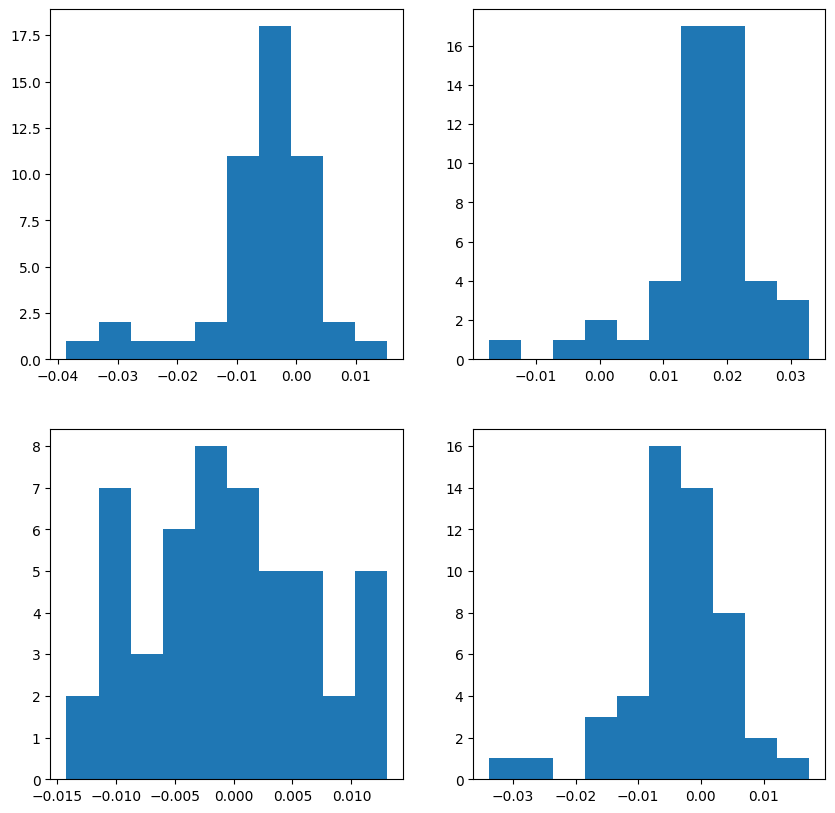

In [28]:
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i,ax in zip(range(len(fair_sim)),axes.ravel()):
    order = results[i].F[:,0].argsort()
    model_residuals = model_sim[i]-np.abs(results[i].F[order,1])
    ax.hist(model_residuals)

In [30]:
sim_n = 0

(X_train, X_test, y_train, y_test, A_train, A_test) = train_test_split(
X_raw, y, A, test_size=0.3, stratify=y, random_state=sim_n
)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)


In [31]:
order = results[sim_n].F[:,0].argsort()
pop = results[sim_n].opt


In [67]:
order = results[sim_n].F[:,0].argsort()
pop = results[sim_n].opt

n_pop = 15

features_ = features[pop.get("X")[n_pop]]
num_features_ = [x for x in num_features if x in features_]
cat_features_ = [x for x in cat_features if x in features_]
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features_),
        ("cat", categorical_transformer, cat_features_),
        
    ], remainder = "drop"
)

pipeline.steps.pop(0)
pipeline.steps.insert(0,('preprocessor',preprocessor))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


metrics = {
    "selection rate": selection_rate,
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall":recall_score,
    "false positive rate": false_positive_rate,
    "true positive rate": true_positive_rate,
    #"false negative rate": false_negative_rate,
    #"demographic parity difference":demographic_parity_difference,
    #"equal opportunity difference":equal_opportunity_difference,
    #"average odds difference": average_odds_difference,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=A_test
)

In [68]:
demographic_parity_difference(y_test, y_pred, sensitive_features=A_test)

0.05312730181749929

In [69]:
metric_frame.by_group

,selection rate,accuracy,precision,recall,false positive rate,true positive rate,count
sex,,,,,,,
Female,0.084981,0.879560,0.443645,0.340074,0.053174,0.340074,4907.0
Male,0.138108,0.780423,0.805349,0.365969,0.038620,0.365969,9746.0


In [65]:
metric_frame.by_group[['selection rate','false positive rate', 'true positive rate','accuracy']].diff().abs()

,selection rate,false positive rate,true positive rate,accuracy
sex,,,,
Female,NaN,NaN,NaN,NaN
Male,0.053127,0.014554,0.025895,0.099137


In [43]:
demographic_parity_difference(y_test, y_pred, sensitive_features=A_test)

0.08193973681039883

In [59]:
fair_residuals = fair_value-np.abs(results[sim_n].F[order,0])
print(np.std(fair_residuals))
print(np.mean(fair_residuals))

0.015081701176977663
0.017647683735156773


In [60]:
model_residuals = model_value-np.abs(results[sim_n].F[order,1]) 
print(np.std(model_residuals))
print(np.mean(model_residuals))

0.008689575816173845
0.012937232423893025


(array([4., 2., 3., 1., 3., 4., 3., 4., 1., 3.]),
 array([-0.00791514, -0.00274331,  0.00242853,  0.00760037,  0.0127722 ,
         0.01794404,  0.02311588,  0.02828771,  0.03345955,  0.03863138,
         0.04380322]),
 <BarContainer object of 10 artists>)

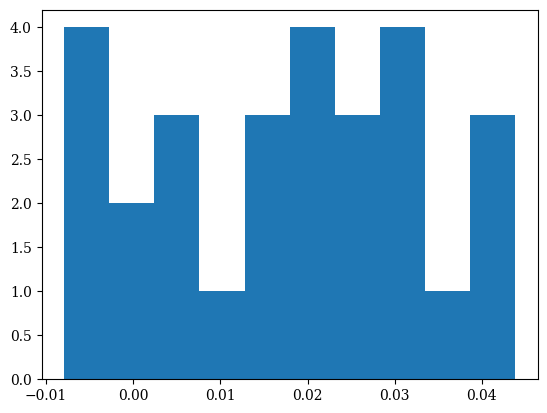

In [61]:
plt.hist(fair_residuals)

(array([1., 1., 2., 1., 4., 7., 8., 3., 0., 1.]),
 array([-0.01084506, -0.00644879, -0.00205252,  0.00234374,  0.00674001,
         0.01113628,  0.01553254,  0.01992881,  0.02432508,  0.02872134,
         0.03311761]),
 <BarContainer object of 10 artists>)

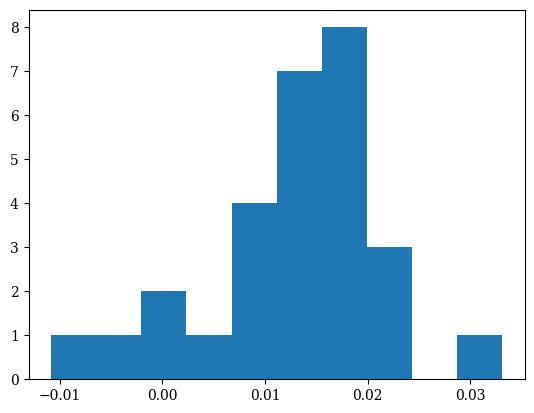

In [62]:
plt.hist(model_residuals)

In [ ]:
feature_dict = {}

for n_pop in order:
    
    print(features[pop.get("X")[n_pop]])